# Grover's Search Algorithm

このチュートリアルでは、シミュレータとイオントラップの実機でGroverの量子アルゴリズムについて学んでいきます。Braket SDKを使用して、単純なモジュラービルディングブロックの量子回路を構築する方法を示します。 具体的には、SDKが提供する基本的なゲートセットを組み合わせたカスタムゲートを構築する方法を示します。 カスタムゲートは、サブルーチンとして登録することにより、コア量子ゲートとして使用できます。

回路を構築した後、シミュレータとIonQの2種類のデバイスで実行します。
後者については、キューで待機している可能性のあるQuantum taskを復元する方法を示します。

1. [Introduction](#introduction)
2. [Background: What is a Quantum Oracle?](#background)
3. [Anatomy of Grover's Algorithm](#steps)
4. [Circuit Diagram](#diagram)
5. [Code](#code)
 1. [Libraries and Parameters](#setup)
 2. [Helper Functions](#wrappers)
 3. [Device: Classical Simulator](#sim_c)
 4. [Device: IonQ](#ionq)
 6. [References](#ref)

このチュートリアルは、下記の論文のイオントラップ実験に基づいています。

This tutorial is based on ion-trap experiments published as *C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7, arXiv:1703.10535*. 

# Introduction<a name="introduction"></a>

グローバーのアルゴリズムは、量子コンピューティングの分野を代表する、基本的な量子アルゴリズムの1つです。 将来的には、量子コンピューティングの特徴的なアプリケーションモジュールとして役立つ可能性があります。 グローバーのアルゴリズムを使用すると、平均 $N/2$ ステップを実行する最良の古典的なアルゴリズムと比較して、$O(\sqrt{N})$ ステップの２次速度加速により、順序付けられていない $N$ 要素のデータベースで特定のレジスタを見つけることができます。

大規模なデータベース（エントリ数が多い$N$）の場合、2次高速化によって大きな利点が得られます。 100万エントリのデータベースの場合、グローバーのアルゴリズムを実行する量子コンピューターは約1000回の実行を必要としますが、従来のコンピューターは平均して50万回の実行を必要とします。

研究によると、非構造化探索問題に対する最適な量子解には、実行時の速度制限が$O(\sqrt{N})$ であることが示されています。この調査結果は、グローバーのアルゴリズムのパフォーマンスと一致しているため、アルゴリズムが漸近的に最適であることが証明されています[2]。実際、次のセクションで説明するように、グローバーのアルゴリズムを一般化して、量子オラクルを構築できるあらゆるタイプの検索を高速化できます。

次の問題を考えてみましょう[2]。
$N$ 個の要素のある検索空間で、0、1、$\dots$、$N-1$ の範囲の数値でこれらの要素のインデックスを検索しています。
$n$ ビットを自由に使用でき、最大 $2^{n}$ 個の要素を格納できます。
次に、関数 $f$ を使用して探索問題を表現できます。この関数は、インデックスのセットから要素（つまり、整数 $x$ ）を入力として受け取り、2つの可能な出力を生成します。$x^{*}$ が探索問題の解である場合は$f(x^{*})=1$を、そうでなければ　$f(x)=0$ を返します（$N<2^{n}$ の場合、余分な未使用の要素すべてに対して$f(x)=0$ を設定）。解探索は量子オラクルを使って実行されます。

# Background: What is a Quantum Oracle? <a name="background"></a>

グローバーのアルゴリズムは、他の多くの量子アルゴリズムと同様に、$\mathcal {O} $　と表記する量子オラクルという概念を利用しています。本質的に、oracle $\mathcal {O} $ は、別のアルゴリズムのサブルーチンとして機能するブラックボックス操作です。通常、オラクルは古典的な関数 $f:\{0,1\}^{n} \rightarrow \{0,1\}^{m}$ を使用して定義され、これは、$n$-入力ビットストリングを $m$-出力ビットストリングにマップします。$x \in \{0,1\}^{n}$、すなわち、$x=(x_{0}, x_{1}, \dots, x_{n-1})$　はビットストリングベクトルであり、$y \in \{0,1\}^{m}$、Oracle $\mathcal{O}$はユニタリ演算子であり、一般に任意のコンピュータへの影響によって定義される任意の計算基底状態:

$$\mathcal{O} (\left|x\right> \otimes \left|y\right>) = \left|x\right> \otimes \left|y \oplus f(x)\right>,$$ ここでは $\oplus$ は追加の modulo 2 を表す。 

これは、サイズ $m$ の 2番目の量子ビットレジスタが計算結果を格納することを意味します。 
ここで注目するシナリオである $m=1$ の場合、2番目のレジスタ $\left|y\right>$  は、$f(x)=1$ の場合にのみフリップされる単一の量子ビットです。 
要するに、量子オラクルは、関数  $f(x)$  が 1 として評価される場合にのみ、アンシラ量子ビットを反転します。 
したがって、$\left|x\right> \otimes \left|0\right>$を最初に状態を準備し、次にその状態にOracle  $\mathcal{O}$ を適用して、最終的にオラクルの量子ビットの状態を測定することによって、$x$が検索問題の解決策であるかどうかを確認できます。 

グローバーのアルゴリズムでは、$\left|y\right> = (\left|0\right> - \left|1\right>)/\sqrt{2}$ として、重ね合わせでオラクルの量子ビットを初期化すると便利です。 
次の2つのケースを区別できます。 
（i）$x$が検索問題の解決策ではない場合（すなわち、$f(x)=0$のとき）、入力状態　$\left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2}$　を入力状態に適用すると、この状態は単に手つかずのままになります。 
(ii) 逆に、$x$が我々の探索問題の解法である場合（すなわち、$f(x)=1$）、オラクル状態の$\left|0\right>$ と $\left|1\right>$が反転し、状態がマイナス記号を拾い、最終的な出力状態 $-\left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2}$となる. 
量子コンピューティングではグローバルな位相因子は重要ではありませんが、ここで遭遇する相対的なマイナス符号は、他のすべての可能な入力状態間の解を含む重ね合わせ状態に対して異なる値となる注意してください。 

(i) と (ii) のどちらの場合も、オラクルのアクションは次のように要約できます。 

$$\left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2} \longrightarrow (-1)^{f(x)} \left|x\right> \otimes (\left|0\right> - \left|1\right>)/\sqrt{2}.$$  
したがって、検索問題の解は、対応する位相をシフトすることによって*マーク* されます。 
オラクル量子ビットは変わらないので、このオラクルキュービットをさらなる議論から省略して、オラクルの動作を次のように表現することができます。 

$$\left|x\right> \longrightarrow (-1)^{f(x)}\left|x\right>.$$ 

この式は、以下の例で使用される*位相オラクル* の定義も含んでいます。 
位相オラクルが計算ベースの状態 $\left|x\right>$ に適用された場合、観測不可能なグローバルフェーズのみが得られます。しかし、計算基底状態の重ね合わせに適用すると、この位相オラクルは強力なツールになります。また、高い確率で解を得るには、探索オラクルを$O(\sqrt{N})$ 回適用する必要があります [2]。一般的には、$G$個の解がある場合は、オラクルは$O(\sqrt{N/G})$ 回の最適実行回数となります。 

# Anatomy of Grover's Algorithm <a name="steps"></a>

このチュートリアルでは、3ビットの$(n=3)$を使用して、8つの探索要素 $(N=2^{3}=8)$を作成します。
特定のターゲットアイテムを見つけるために、グローバーのアルゴリズムは次の手順を使用します。



1. **初期化**： アダマールゲートを適用して、可能なすべてのビット文字列を均一に重ね合わせることから始めます。これにより、すべての入力の振幅が同じになります。ソリューションに関する事前の知識がないため、考えられるすべての候補ソリューションを均等に重ね合わせて初期化します。

2. **Oracle**： アイテムビットはオラクルを介して渡されます。オラクルは2つの結果しか生成しません。ターゲットアイテムを検出すると、その振幅を負に反転します。他のすべてのアイテムについては、それらの振幅は正のままになります。オラクルは特定のビットパターンに基づいて振幅を変更するように特別に設計されているため、各ターゲットアイテムには独自のオラクルが関連付けられます。

3. **増幅**： ステップ2のオラクルは、振幅を負の方向に反転させることでターゲットアイテムを区別しますが、この差は小さすぎて検出できません。したがって、振幅の違いを拡大するためにトリックを使用します。平均振幅の周りのすべての振幅を反転することによって。ターゲットアイテムの振幅のみが負に反転したことを思い出してください。言い換えると、平均振幅は依然として正であり、その値は他のアイテムの振幅よりもわずかに低いだけです。平均値を中心にすべての振幅を反転することにより、対象外のアイテムの振幅はわずかに減少します。一方、ターゲットアイテムの振幅は、開始する平均値よりもはるかに小さいため、大きなマージンで正の方向に反映されます。

4. **繰り返し**： 手順2と3を繰り返すことで、ターゲットアイテムの振幅を、圧倒的な確率で識別できるポイントまで拡大できます。この点に到達するには、これらの手順を約$\sqrt{N}$ 回繰り返す必要があります（ここでも、単一のソリューションと大きな　$N$　を想定しています）。 Quantum Amplification Algorithm（QAA）チュートリアルで詳細に説明されているように、高い確率で解を測定するために、Groverイテレーター$\left\lfloor\frac{\pi}{4\theta}\right\rfloor=\left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{G}}\right\rfloor$ を適用します。  $G$ は解の数を示します。事前に $G$がわからない可能性があるため、事前に理想的な反復回数がわかりません。ただし、この問題に対処するために、位相推定手順（QPE）を使用して量子カウント手法を使用する場合があります。詳細については、参考文献[2]を参照してください。

5. **測定**： 結果の振幅を測定して、ターゲットアイテムを特定します。

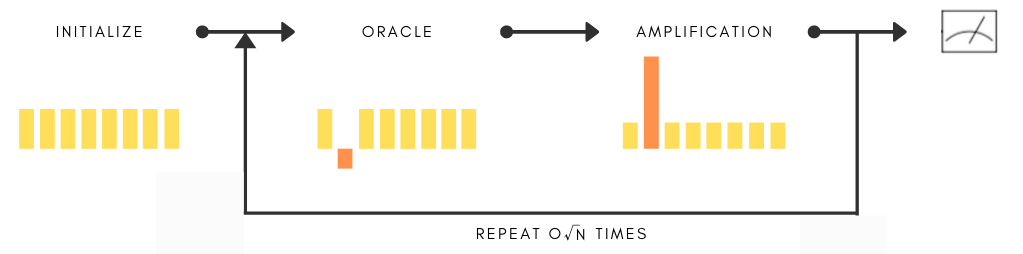

# Circuit Diagram <a name="diagram"></a>

Ref. [1] にしたがって、$n=3$ 量子ビットに対するグローバーの検索アルゴリズムを実行します。これは、サイズ $N = 2^{3} = 8$ の検索データベースに対応します。以下に、項目 ```111```　を見つけるために使用される回路を示します。他のアイテムを見つけるには、Ref. [1] で与えられたテーブルを使用して、位相オラクルを交換するだけです。

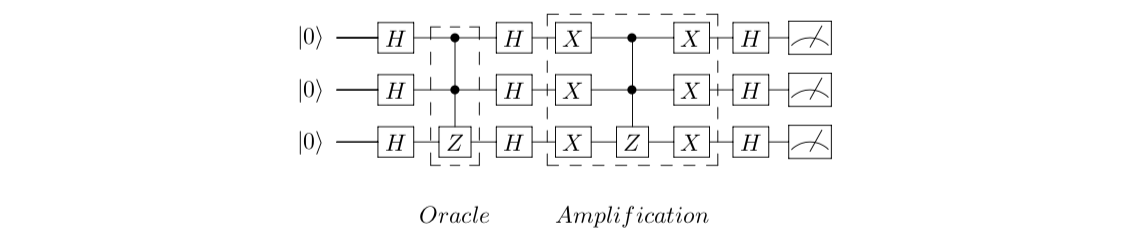

# Code <a name="code"></a>

## Libraries and Parameters <a name="setup"></a>

In [ ]:
# Check SDK version
!pip show amazon-braket-sdk | grep Version

In [ ]:
# Import Braket libraries
from braket.circuits import circuit, Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.aws import AwsQuantumTask, AwsDevice
from braket.devices import LocalSimulator
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import numpy as np

__NOTE__: 利用したいデバイスと S3 の場所 (バケットとキー) を下に入力します。ローカルシミュレータ ```localSimulator () ```を使用する場合は、S3 の場所を指定する必要はありません。ただし、マネージドシミュレータデバイスまたは任意の QPU デバイスを使用している場合は、結果が保存される S3 の場所を指定する必要があります。この場合、以下の API コール  ```device.run(circuit, ...)```　を  ```device.run(circuit, s3_folder, ...)```に置き換える必要があります。 

## [下記のセルはご自身で設定が必要です]

In [ ]:
# set up device: Local Simulator
device = LocalSimulator()

#  Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

## Helper Functions <a name="wrappers"></a>

以下で、便利なヘルパー関数を開発します。具体的には、Grover の検索アルゴリズムの 4 つのコアモジュール 1) 初期化、2) オラクル、3) 増幅、4) 測定の単純な構成要素を提供します。このアプローチにより、完結でモジュール化された方法で問題を解くことができます。

In [ ]:
# Helper function to build C-C-Z gate
@circuit.subroutine(register=True)
def ccz(targets=[0, 1, 2]):
    """
    implementation ot three-qubit gate CCZ
    """
    # define three-qubit CCZ gate
    ccz_gate = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0]],
                       dtype=complex)
    
    # instantiate circuit object
    circ = Circuit()
    
    # add CCZ gate
    circ.unitary(matrix=ccz_gate, targets=targets)
    
    return circ


# All possible items and their corresponding oracles
# define oracle dictionary using this CCZ gate
oracle_sim = {"000": Circuit().x([0,1,2]).ccz(targets=[0, 1, 2]).x([0,1,2]),
              "001": Circuit().x([0,1]).ccz(targets=[0, 1, 2]).x([0,1]),
              "010": Circuit().x([0,2]).ccz(targets=[0, 1, 2]).x([0,2]),
              "011": Circuit().x([0]).ccz(targets=[0, 1, 2]).x([0]),
              "100": Circuit().x([1,2]).ccz(targets=[0, 1, 2]).x([1,2]),
              "101": Circuit().x([1]).ccz(targets=[0, 1, 2]).x([1]),
              "110": Circuit().x([2]).ccz(targets=[0, 1, 2]).x([2]),
              "111": Circuit().ccz(targets=[0, 1, 2])
          }


# helper function for initialization
def initialize(n_qubits=3):
    """
    function to apply hadamard to all qubits
    """
    # Initialize with superposition
    circ = Circuit();
    circ.h(np.arange(n_qubits))
    #print(circ)
    return circ


# helper function for phase oracle
def oracle(item):
    """
    function to apply oracle for given target item
    """
    # instantiate circuit object
    circ = Circuit()
    
    # add oracle
    circ.add_circuit(oracle_sim[item])
    
    return circ


# helper function for amplification
def amplify(n_qubits=3):
    """
    function for amplitude amplification
    """
    # instantiate circuit object
    circ = Circuit()
    
    # Amplification
    circ.h(np.arange(n_qubits))
    circ.add_circuit(oracle_sim['000'])
    circ.h(np.arange(n_qubits))
    
    return circ


# helper function for grover algorithm
def grover(item, n_qubits=3, n_reps=1):
    """
    function to put together individual modules of Grover algorithm
    """
    # initalize
    grover_circ = initialize()
    # oracle and amplify
    for ii in range(n_reps):
        # get oracle
        or_circ = oracle(item)
        grover_circ.add(or_circ)
        # amplify
        amplification = amplify()
        grover_circ.add(amplification)
    
    return grover_circ
        

In [ ]:
# Function to run quantum task, check the status thereof, and collect results
def get_result(circ, s3_folder):
    
    # get number of qubits
    num_qubits = circ.qubit_count

    # specify desired results_types
    circ.probability()

    # submit task: define task (asynchronous)
    if device.name == 'DefaultSimulator':
        task = device.run(circ, shots=1000)
    else:
        task = device.run(circ, s3_folder, shots=1000)

    # Get ID of submitted task
    task_id = task.id
#     print('Task ID :', task_id)

    # Wait for job to complete
    status_list = []
    status = task.state()
    status_list += [status]
    print('Status:', status)

    # Only notify the user when there's a status change
    while status != 'COMPLETED':
        status = task.state()
        if status != status_list[-1]:
            print('Status:', status)
        status_list += [status]

    # get result
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # get output probabilities
    probs_values = result.values[0]

    # get measurment results
    measurement_counts = result.measurement_counts

    # print measurment results
    print('measurement_counts:', measurement_counts)

    # bitstrings
    format_bitstring = '{0:0' + str(num_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # plot probabalities
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);
    
    return measurement_counts

## Device: Classical Simulator <a name="sim_c"></a>
まず Grover のアルゴリズムを古典的なシミュレータでデモンストレーションします。 
ローカルシミュレータまたはマネージドシミュレータのいずれかを選択できます。 
次のセクションでは、同じ問題をQuantum IonQデバイスで実行します。

In [ ]:
# Set up the cloud-based simulator 
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# set up the local simulator
# device = LocalSimulator()

In [ ]:
# get device name
device_name = device.name
# show the properties of the device 
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
# Note: This field also exists for other devices like the QPUs
print('Quantum Gates supported by {}:\n {}'.format(device_name, device_operations))

```CCZ``` ゲートはデフォルトのゲートセットの一部ではないので、位相オラクル演算子用のカスタムで二重制御のZゲート ```CCZ```を構築するために ```unitary``` メソッドを使用しました。 
Amazon Braket の`circuit.subroutine`機能を活用することにより、このようなカスタムビルドのゲートを、あたかも他の組み込みゲートであるかのように使用できます。  

これで、いくつかのテストケースで回路を実行する準備が整いました。 
要約すると、手順は次のとおりです。

1. 一様な重ね合わせを作成する
2. ターゲットアイテムに対応する位相オラクルを適用する
3. 拡散演算子を定義して、オラクルによって生成された振幅差を拡大します。
4. ターゲットアイテムの測定数を収集する

In [ ]:
# Select item to find. Let's start with '111' for now
item = "111"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ, s3_folder)

__DISCUSSION__: `111` ビットストリングによって与えられるターゲット解の周囲に強いピークが見られ、他のすべてのビットストリングははるかに小さい確率を示しています。 別の解候補のパターンを下記で試してみましょう。

In [ ]:
# Select item to find. Let's start with '111' for now
item = "100"

# get Grover circuit
circ = grover(item)

# print circuit
print(circ)

# Measurement
counts = get_result(circ, s3_folder)

__DISCUSSION__: ステップ2（オラクル）と3（増幅）を繰り返すことで、ターゲットアイテムの振幅をさらに拡大し、正しい答えを特定するシングルショット確率を最大化できます。この繰り返しを以下に示します。

In [ ]:
# Select item to find
item = "100"

# get Grover circuit
circ = grover(item, n_reps=2)

# print circuit
print(circ)

# Measurement
counts = get_result(circ, s3_folder)

__DISCUSSION__: Grover 演算子の繰り返し適用によって、目的のビットストリングの発生がより高くなったことがわかると思います。これにより、より高い確率で正しい結果を得ることができます。

## Device: IonQ <a name="ionq"></a>

最後に、このスキームが量子ハードウェアで動作するかどうかを確認し、回路をionQデバイスに送信します。このチェックを行うには、まず ```CCZ``` ゲートを ionQ のネイティブゲートセットで表現する必要があります。その際、サブルーチンとして登録し、SDK内の他のネイティブ量子ゲートであるかのように使用できるカスタムゲートを構築します。 

In [ ]:
# Set up a QPU device
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

In [ ]:
# get device name
device_name = device.name
# show the properties of the device 
device_properties = device.properties
# show supportedQuantumOperations (supported gates for a device)
device_operations = device_properties.dict()['action']['braket.ir.jaqcd.program']['supportedOperations']
# Note: This field also exists for other devices like the QPUs
print('Quantum Gates supported by {}:\n {}'.format(device_name, device_operations))

Figgatt et al. (2017) に示されている3つの量子ビットを持つ=8 Groverのデモでは、ionQデバイスにネイティブで提供されていない制御制御Z ```CCZ``` ゲートを実装する必要があります。このゲートは、```CNOT``` や ``T`` などのネイティブゲートのみを使用して構築します。実装とは別に、他の代替オプションも利用できます ([1] とその中の参考文献を参照)。 

In [ ]:
@circuit.subroutine(register=True)
def CCNot(controls=[0, 1], target=2):
    """
    build CCNOT from H, CNOT, T, Ti
    """
    cQb1, cQb2 = controls
    circ = Circuit().h(target).cnot(cQb2,target).ti(target).cnot(cQb1,target).t(target).cnot(cQb2,target).ti(target).cnot(cQb1,target).t(target).h(target).t(cQb2).cnot(cQb1,cQb2).t(cQb1).ti(cQb2).cnot(cQb1,cQb2)
    
    return circ 

def CCZ_ionq(controls=[0, 1], target=2):
    """
    build CCZ from H and CCNOT
    """
    circ = Circuit().h(target).CCNot(controls, target).h(target)
    return circ

ccz_ionq = CCZ_ionq()

ターゲットアイテムに基づいて定義されるオラクルは次のとおりです。

In [ ]:
# Four possible items and their corresponding oracles
oracle_ionq = {"000": Circuit().x([0,1,2]).add(ccz_ionq).x([0,1,2]),
               "001": Circuit().x([0,1]).add(ccz_ionq).x([0,1]),
               "010": Circuit().x([0,2]).add(ccz_ionq).x([0,2]),
               "011": Circuit().x([0]).add(ccz_ionq).x([0]),
               "100": Circuit().x([1,2]).add(ccz_ionq).x([1,2]),
               "101": Circuit().x([1]).add(ccz_ionq).x([1]),
               "110": Circuit().x([2]).add(ccz_ionq).x([2]),
               "111": Circuit().add(ccz_ionq)
          }

In [ ]:
# Select some example item to find
item = "111"

古典的なシミュレータと同様に、まずすべての量子ビットにアダマールゲート ```H``` を適用して量子ビットを初期化します。

In [ ]:
# Initialize with superposition
circ = Circuit();
circ.h(np.arange(3))
print(circ)

次に、ターゲットアイテムに対応する位相オラクルを適用します。

In [ ]:
# Construct phase oracle
circ.add_circuit(oracle_ionq[item])
print(circ)

回路を完成させるために、拡散演算子を定義します。拡散演算子の役割は、オラクルによって生成された振幅差を拡大することです。

In [ ]:
# Amplification
circ.h(np.arange(3))
circ.add_circuit(oracle_ionq['000'])
circ.h(np.arange(3))
print(circ)

この回路は、Ref. [1] で詳述されているように最適化できる可能性がありますが、ここでは簡略化のためにこのバージョンを使用します。 

最後のステップでは、ターゲット項目の確率的カウントを取得します。 
この目的のために、デバイスを ```awsDevice (「arn: aws: braket።: device/QPU/ionQ/ionqDevice」) ```として設定することにより、回路を IonQ デバイスに送信します。 

このタスクは、このマシンのキューに入るとすぐに実行されない場合があります。 
他の作業を行うためにカーネルを中断する必要がある場合、次の行に示すように、このタスクの一意のIDを使用して結果をいつでも回復できます。 

In [ ]:
# set up device
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

# run circuit 
ionq_task = ionq.run(circ, s3_folder, shots=1000)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

In [ ]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

In [ ]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

In [ ]:
# recover task
task_load = AwsQuantumTask(arn=ionq_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values());
    plt.xlabel('bitstrings');
    plt.ylabel('counts');
    plt.tight_layout();
    plt.savefig('ionq.png', dpi=700);
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

この比較的長いゲートシーケンスでは、デコヒーレンスとゲート誤差が原因で、出力は比較的ノイズが多いように見えます。ただし、ターゲットアイテムの主要なピークは引き続き観察できます。 

このノートブックでは、単純なモジュラー構成要素を使用して、Grover の検索アルゴリズムを古典的なシミュレータと IonQ デバイスに実装する方法を示しました。また、SDK が提供する基本ゲートセットの外側にカスタムゲートを構築する方法と、これらを他の事前定義された量子ゲートであるかのように使用できるサブルーチンとして登録する方法を解説しました。 

---
# References <a name="ref"></a>

[1] C. Figgatt, D. Maslov, K. A. Landsman, N. M. Linke, S. Debnath & C. Monroe (2017), "Complete 3-Qubit Grover search on a programmable quantum computer", Nature Communications, Vol 8, Art 1918, doi:10.1038/s41467-017-01904-7, arXiv:1703.10535.

[2] Nielsen, Michael A., Chuang, Isaac L. (2010). Quantum Computation and Quantum Information (2nd ed.). Cambridge: Cambridge University Press.